### Music Genre Classification using K-nearest neighbor 


In [3]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import pandas as pd
import numpy as np

from tempfile import TemporaryFile
import os
import pickle
import random
import operator
from sklearn.metrics import confusion_matrix,classification_report
import math
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
dataset=pd.read_csv("C:/Users/RIYA/Desktop/jupyter/Data/features_30_sec.csv")
dataset.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [5]:
dataset.tail()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock
999,rock.00099.wav,661794,0.358401,0.085884,0.054454,0.000336,1609.795082,422203.216152,1797.213044,120115.632927,...,59.167755,-7.069775,73.760391,0.028346,76.504326,-2.025783,72.189316,1.155239,49.662510,rock


In [6]:
# function to get the distance between feature vecotrs and find neighbors
def getNeighbors(trainingSet, instance, k):
    distances = []
    for x in range(len(trainingSet)):
        dist = distance(trainingSet[x], instance, k) + distance(instance, trainingSet[x], k)
        distances.append((trainingSet[x][2], dist))

    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    
    return neighbors

In [7]:
# identify the class of the instance
def nearestClass(neighbors):
    classVote = {}

    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1

    sorter = sorted(classVote.items(), key = operator.itemgetter(1), reverse=True)

    return sorter[0][0]

In [8]:
# function to evaluate the model
def getAccuracy(testSet, prediction):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == predictions[x]:
            correct += 1
    
    return (1.0 * correct) / len(testSet)


#### Feature Extraction
###### Mel Frequency Cepstral Coefficients:
These are state-of-the-art features used in automatic speech and speech recognition studies.



In [9]:
# directory that holds the wav files
directory = "C:/Users/RIYA/Desktop/jupyter/Data/genres_original/"
# binary file where we will collect all the features extracted using mfcc (Mel Frequency Cepstral Coefficients)
f = open("my.dat", 'wb')

i = 0

for folder in os.listdir(directory):
    i += 1
    if i == 11:
        break
    for file in os.listdir(directory+folder):        
        try:
            (rate, sig) = wav.read(directory+folder+"/"+file)
            mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)
            covariance = np.cov(np.matrix.transpose(mfcc_feat))
            mean_matrix = mfcc_feat.mean(0)
            feature = (mean_matrix, covariance, i)
            pickle.dump(feature, f)
        except Exception as e:
            print('Got an exception: ', e, ' in folder: ', folder, ' filename: ', file)        

f.close()

Got an exception:  File format b'\xcb\x15\x1e\x16' not understood. Only 'RIFF' and 'RIFX' supported.  in folder:  jazz  filename:  jazz.00054.wav


In [10]:
# Split the dataset into training and testing sets respectively
dataset = []

def loadDataset(filename, split, trSet, teSet):
    with open('my.dat', 'rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trSet.append(dataset[x])
        else:
            teSet.append(dataset[x])
trainingSet = []
testSet = []
loadDataset('my.dat', 0.66, trainingSet, testSet)


In [11]:
def distance(instance1 , instance2 , k ):
    distance =0 
    mm1 = instance1[0] 
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1)) 
    distance+=(np.dot(np.dot((mm2-mm1).transpose() , np.linalg.inv(cm2)) , mm2-mm1 )) 
    distance+= np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance-= k
    return distance

In [12]:
# making predictions using KNN
leng = len(testSet)
predictions = []
for x in range(leng):
    predictions.append(nearestClass(getNeighbors(trainingSet, testSet[x], 5)))

accuracy1 = getAccuracy(testSet, predictions)
print(accuracy1)


0.6858974358974359


In [13]:
y_true = []
y_pred = np.array(predictions)
for i in testSet:
    y_true.append(i[-1])
y_true = np.array(y_true)

cm  = confusion_matrix(y_true,y_pred)
    
print(cm)

[[30  0  1  0  1  0  0  0  1  3]
 [ 0 32  0  1  0  0  0  0  0  1]
 [ 2  0 17  2  1  0  0  1  2  0]
 [ 0  0  1 20  3  0  0  3  0  5]
 [ 0  0  0  1 18  0  1  2  4  2]
 [ 1  5  3  2  1 15  0  1  2  2]
 [ 0  0  1  2  1  0 26  0  0  4]
 [ 0  0  0  1  1  0  0 24  4  1]
 [ 0  0  0  1  5  0  0  0 19  1]
 [ 3  0  1 10  4  0  0  0  3 13]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



confution matrix plot


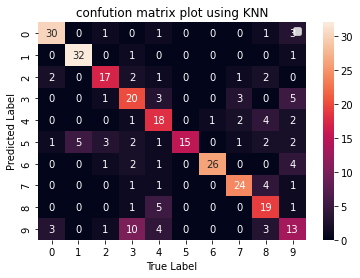

              precision    recall  f1-score   support

           1       0.83      0.83      0.83        36
           2       0.86      0.94      0.90        34
           3       0.71      0.68      0.69        25
           4       0.50      0.62      0.56        32
           5       0.51      0.64      0.57        28
           6       1.00      0.47      0.64        32
           7       0.96      0.76      0.85        34
           8       0.77      0.77      0.77        31
           9       0.54      0.73      0.62        26
          10       0.41      0.38      0.39        34

    accuracy                           0.69       312
   macro avg       0.71      0.68      0.68       312
weighted avg       0.72      0.69      0.69       312



<Figure size 432x288 with 0 Axes>

In [14]:
sns.heatmap(cm,annot=True)
plt.title('confution matrix plot using KNN')
print("\nconfution matrix plot")
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.legend()
plt.show()
plt.savefig('cnn_cm_ritam.png')

print(classification_report(y_true,y_pred))

In [39]:
# testing the code with external samples
test_dir = "C:/Users/RIYA/Desktop/jupyter/Data/Test/"
#test_file = test_dir + "test1.wav"
#test_file = test_dir + "test2.wav"
#test_file = test_dir + "test3.wav"
#test_file = test_dir + "Michael_Jackson_smooth_criminal.wav"
#test_file = test_dir +"Neele Neele Ambar.wav"
test_file = test_dir + "Michael_Jackson_-_Dangerous.wav"

In [40]:
(rate, sig) = wav.read(test_file)
mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)
covariance = np.cov(np.matrix.transpose(mfcc_feat))
mean_matrix = mfcc_feat.mean(0)
feature = (mean_matrix, covariance, i)


In [41]:
from collections import defaultdict
results = defaultdict(int)

directory = "C:/Users/RIYA/Desktop/jupyter/Data/genres_original/"

i = 1
for folder in os.listdir(directory):
    results[i] = folder
    i += 1

In [42]:
pred = nearestClass(getNeighbors(dataset, feature, 5))
print(results[pred])

reggae
